## A notebook to evaluate the error in the convection term

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/midterm")

"/Users/jeff/Dropbox/MAE250H/julia/midterm/Project.toml"

In [2]:
using Revise
using Random
using LinearAlgebra
using Plots
using project1

### Basic differencing operations

In [3]:
?diff!

search: diff! symdiff! setdiff! diff diffuse2d_dirichlet_cn



```
diff!(p::CellData,u::XEdgeData)
```

Compute the x difference of x-edge data `u` at cell centers and place the result in `p`. Only interior cells are updated.

---

```
diff!(p::CellData,v::YEdgeData)
```

Compute the x difference of y-edge data `v` at cell centers and place the result in `p`. Only interior cells are updated.

---

```
diff!(u::XEdgeData,p::CellData)
```

Compute the x difference of cell data `p` at x edges and place the result in `u`.

---

```
diff!(v::YEdgeData,p::CellData)
```

Compute the x difference of cell data `p` at y edges and place the result in `v`.

---

```
diff!(s::NodeData,u::XEdgeData)
```

Compute the y difference of x-edge data `u` at nodes and place the result in `s`.

---

```
diff!(s::NodeData,v::YEdgeData)
```

Compute the x difference of y-edge data `v` at nodes and place the result in `s`.

---

```
diff!(u::XEdgeData,s::NodeData)
```

Compute the y difference of node data `s` at x edges and place the result in `u`. Note that only interior edges are updated.

---

```
diff!(v::YEdgeData,s::NodeData)
```

Compute the x difference of node data `s` at y edges and place the result in `v`. Note that only interior edges are updated.


In [5]:
p = CellData(64,64)
q = EdgeData(p)
q.qx .= randn(size(q.qx))
@time diff!(p,q.qx);

  0.000039 seconds (11 allocations: 65.000 KiB)


In [6]:
p = CellData(p)
transpose(q.qy) .= 1:65
@time diff!(p,q.qy)
norm(p)

  0.082695 seconds (191.71 k allocations: 9.133 MiB, 11.13% gc time)


1.0

Here is a Hadamard (i.e. element by element) product:

In [8]:
p = CellData(p)
p*p

66×66 CellData{64,64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [9]:
s = NodeData(64,64)
q = EdgeData(s)
q.qx .= 1:65;
q.qy .= 1:66;
@time diff!(s,q.qx)
norm(s)

  0.260966 seconds (948.68 k allocations: 43.476 MiB, 7.70% gc time)


0.0

In [10]:
@time diff!(s,q.qy)
norm(s)

  0.214768 seconds (771.96 k allocations: 35.174 MiB, 5.06% gc time)


1.0

In [11]:
s = NodeData(64,64)
interpolate!(s,q.qx)
s[32,45]

32.0

### Computing the non-linear convection term

#### First set the parameters

In [12]:
LX = 1  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

In [13]:
NX = 128
NY = 128
Δx = LX/NX

0.0078125

#### Set up a function to evaluate

Start with a streamfunction, so that we are guaranteed to have a divergence-free velocity

$$\psi(x,y) = \sin(P\pi x)\sin(Q\pi y)$$

so that

$$\mathbf{u}\cdot\nabla\mathbf{u} = \frac{\pi^3}{2} (P Q^2 \sin (2\pi P x), P^2 Q \sin(2\pi Q y))$$

In [16]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = π*Q*sin(π*P*x)
uT(x,t) = π*Q*(-1)^Q*sin(π*P*x)

vL(y,t) = -π*P*sin(π*Q*y)
vR(y,t) = -π*P*(-1)^P*sin(π*Q*y)
vB(x,t) = 0.0
vT(x,t) = 0.0

vT (generic function with 1 method)

In [17]:
ν = 1
Fo = 0.5
Δt = Fo*Δx^2/ν
params = VectorPoissonParameters(Δx,x0,y0,uL,uR,uB,uT,vL,vR,vB,vT)

VectorPoissonParameters(0.0078125, 0.0, 0.0, uL, uR, uB, uT, vL, vR, vB, vT)

In [18]:
P = 3
Q = 1
s = NodeData(NX,NY)
i_n = indices(s,1,interior=false)
j_n = indices(s,2,interior=false)
x = xmap(i_n,s,params);
y = ymap(j_n,s,params);
for j in j_n, i in i_n
    s[i,j] = sin(P*π*x[i])*sin(Q*π*y[j])
end

Now the exact calculation of the non-linear term

In [19]:
q = EdgeData(s);

In [20]:
i_qx, i_qy = indices(q,1,interior=false)
j_qx, j_qy = indices(q,2,interior=false)

x_qx = xmap(i_qx,q.qx,params);
y_qx = ymap(j_qx,q.qx,params);
x_qy = xmap(i_qy,q.qy,params);
y_qy = ymap(j_qy,q.qy,params);

nlexact = EdgeData(s)
for j in j_qx, i in i_qx
    nlexact.qx[i,j] = 0.5*π^3*P*Q^2*sin(2*P*π*xmap(i,q.qx,params))
end
for j in j_qy, i in i_qy
    nlexact.qy[i,j] = 0.5*π^3*P^2*Q*sin(2*Q*π*ymap(j,q.qy,params))
end

Here is the streamfunction field

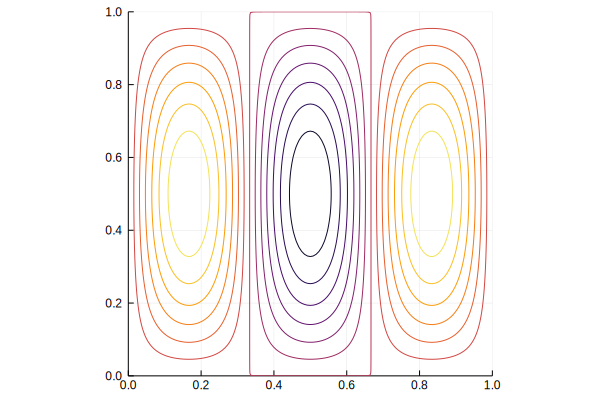

In [21]:
contour(x,y,transpose(s),legend=false,ratio=1)

Compute the velocity field and enforce the boundary conditions

In [22]:
q = curl(s)/Δx;

In [23]:
apply_bc!(q,0,params);

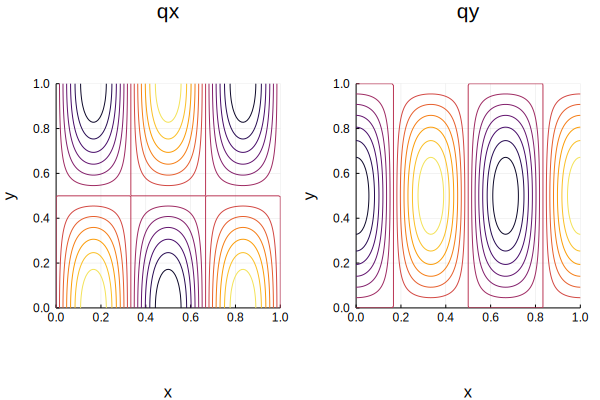

In [24]:
p1 = contour(x_qx,y_qx,transpose(q.qx[i_qx,j_qx]),legend=false,title="qx")
p2 = contour(x_qy,y_qy,transpose(q.qy[i_qy,j_qy]),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(x_qx[1],x_qx[end]),ylim=(y_qy[1],y_qy[end]))

Now compute the non-linear convective term and plot it

In [25]:
@time nl = convection(q)/Δx;

  0.621336 seconds (1.72 M allocations: 82.212 MiB, 8.43% gc time)


For error calculation purposes only, set the boundary values to the exact values

In [26]:
nluL(y,t) = 0.0
nluR(y,t) = 0.0
nluB(x,t) = π^3/2*P*Q^2*sin(2*π*P*x)
nluT(x,t) = π^3/2*P*Q^2*sin(2*π*P*x)

nlvL(y,t) = π^3/2*P^2*Q*sin(2*π*Q*y)
nlvR(y,t) = π^3/2*P^2*Q*sin(2*π*Q*y)
nlvB(x,t) = 0.0
nlvT(x,t) = 0.0

nlparams = VectorPoissonParameters(Δx,x0,y0,nluL,nluR,nluB,nluT,nlvL,nlvR,nlvB,nlvT)

apply_bc!(nl,0,nlparams);

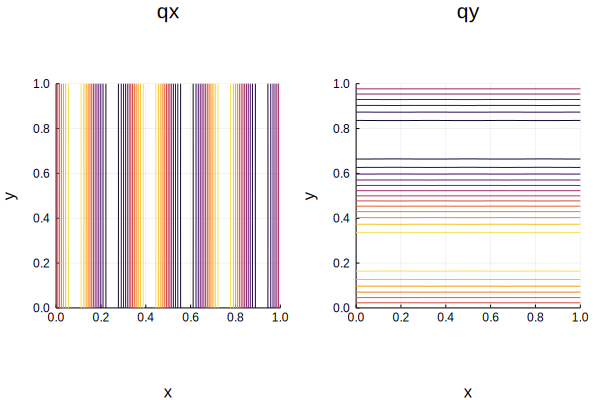

In [27]:
p1 = contour(x_qx,y_qx,transpose(nl.qx[i_qx,j_qx]),legend=false,title="qx")
p2 = contour(x_qy,y_qy,transpose(nl.qy[i_qy,j_qy]),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(x_qx[1],x_qx[end]),ylim=(y_qy[1],y_qy[end]))

Compute the error

In [28]:
norm(nl-nlexact)/norm(nlexact)

0.0013040809986445056